# UR Desa Sentinel 10m TC

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor True crop, input tingkat desa.

### Import Fast Ai

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [3]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
from sklearn import metrics

In [5]:
from sklearn.model_selection import StratifiedKFold

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/UR/07. Resolution compare desa sentinel.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [7]:
def plot_multroc(tst_preds, k =5):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots( figsize=(9,7))
    for i in range(0,k):
        fpr, tpr, thresholds = metrics.roc_curve(tst_preds[i][1], tst_preds[i][0][:,1])
        roc_auc = metrics.auc(fpr, tpr)
        viz = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name="ROC fold {}".format(i))
        viz.plot(ax = ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.35,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")

    plt.show()

Buka data variabel

Proses pembentukan dan distribusi citra ke folder urban rural untuk citra bersesuaian sesuai dengan format fast ai

### Run Dataset

**SENTINEL**

Preprocessing penyiapan data citra untuk diload perbatch ke fast ai.

In [34]:
path = Path.cwd() / ("07. Resolution compare desa sentinel")

Pembentukan data block

In [35]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

Load dan print conto batch

In [36]:
dls = blocks.dataloaders(path)

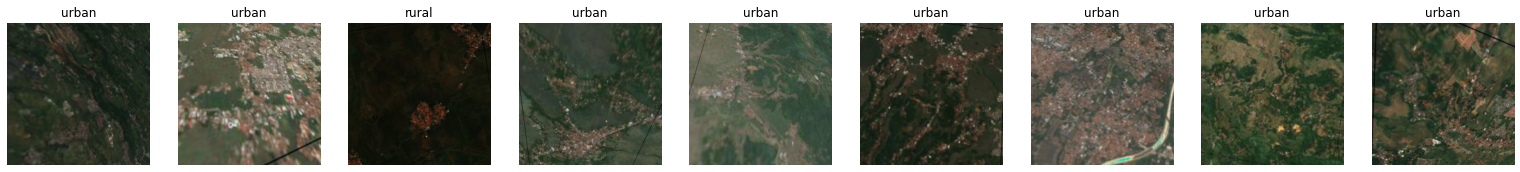

In [37]:
dls.show_batch(nrows=1)

In [38]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metricsc=[accuracy,bc, Precision(), Recall(),Recall(pos_label=0), f1s, roca]


Mencari batas maksimum untuk learning rate

SuggestedLRs(valley=0.0010000000474974513)

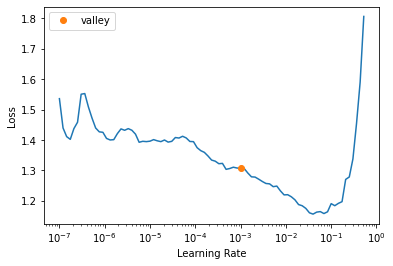

In [39]:
learn = vision_learner(dls, densenet121, metrics=metrics) 
learn.lr_find()

Smith fit one cycle terhadap densenet

In [40]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items


In [41]:
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn = vision_learner(dls, densenet121, metrics=metricsc) 
    learn.fit_one_cycle(3,1e-2)
    val_pct.append(learn.validate())
    tst_preds.append(learn.get_preds(ds_idx=1))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.703419,0.679193,0.776952,0.640793,0.788009,0.946015,0.335570,0.657179,0.779934,00:26
1,0.518173,0.367294,0.841078,0.780374,0.870574,0.916452,0.644295,0.792408,0.899372,00:26
2,0.365907,0.373315,0.834572,0.778981,0.872208,0.903599,0.654362,0.787123,0.893588,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.688398,0.438264,0.821561,0.708328,0.836485,0.943538,0.473118,0.732870,0.859226,00:26
1,0.491580,0.440401,0.816914,0.766924,0.880711,0.870765,0.663082,0.764134,0.877223,00:26
2,0.356029,0.388250,0.818773,0.751872,0.867971,0.890841,0.612903,0.758064,0.879535,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.717687,0.696993,0.766729,0.580972,0.768924,0.975980,0.185965,0.578543,0.799836,00:26
1,0.561163,0.740612,0.817844,0.694298,0.823721,0.957016,0.431579,0.720971,0.844922,00:26
2,0.417445,0.373181,0.829926,0.785563,0.887755,0.879899,0.691228,0.783326,0.893018,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.690917,0.556454,0.781395,0.583263,0.786640,0.974074,0.192453,0.586526,0.846506,00:26
1,0.534929,0.389070,0.816744,0.794608,0.911409,0.838272,0.750943,0.771110,0.899525,00:26
2,0.427970,0.371405,0.847442,0.781971,0.889157,0.911111,0.652830,0.789216,0.892057,00:26


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.704333,0.477045,0.790698,0.676452,0.832383,0.903465,0.449438,0.691299,0.827261,00:26
1,0.574323,0.590812,0.818605,0.794070,0.909212,0.842822,0.745318,0.772961,0.853358,00:26
2,0.393729,0.358636,0.839070,0.770069,0.882070,0.907178,0.632959,0.777948,0.891687,00:26


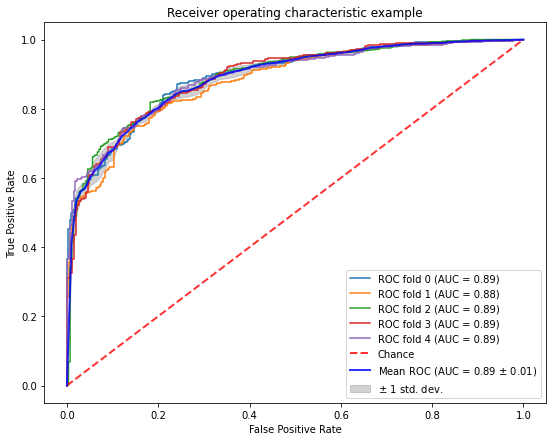

In [42]:
plot_multroc(tst_preds, k = 5)

In [43]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/07. sentinel predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)

In [44]:
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/07. sentinel.csv")

Pemodelan densenet dengan metrik bersesuaian

In [45]:
pd.DataFrame(val_pct).mean()

0    0.372957
1    0.833957
2    0.773691
3    0.879832
4    0.898526
5    0.648857
6    0.779135
7    0.889977
dtype: float64

**SPOT**

In [ ]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/dataset/UR/08. Resolution compare desa SPOT.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [47]:
path = Path.cwd() / ("08. Resolution compare desa SPOT")

In [48]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 item_tfms = Resize(224)) # data augmentation (mult multiplies the default transformation values)

In [49]:
dls = blocks.dataloaders(path)

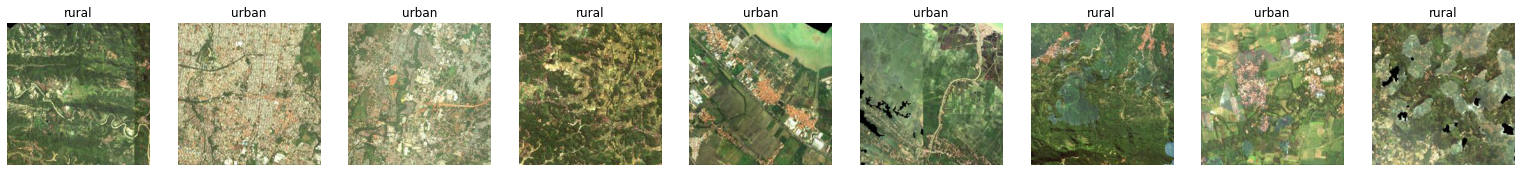

In [50]:
dls.show_batch(nrows=1)

SuggestedLRs(valley=0.001737800776027143)

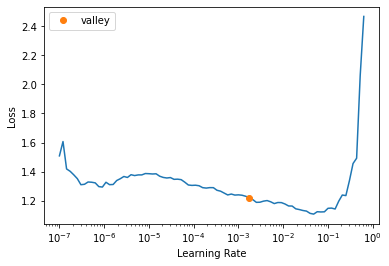

In [51]:
learn = vision_learner(dls, densenet121, metrics=metrics) 
learn.lr_find()

In [52]:
Image.MAX_IMAGE_PIXELS = None

In [53]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_labels = L(dls.train.items).map(dls.tfms[1])
valid_labels = L(dls.valid.items).map(dls.tfms[1])
train_labels = train_labels +valid_labels
train_imgs = dls.train.items
tst_imgs = dls.valid.items


In [54]:
val_pct = []
tst_preds = []
test_lab = []
for train_idx, val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=IndexSplitter(val_idx),  # default random split 80% training, 20% validation
                 get_y=parent_label,
                 item_tfms = Resize(224)) # data augmentation (mult multiplies the default transformation values)
    dls = blocks.dataloaders(path)
    learn = vision_learner(dls, densenet121, metrics=metricsc) 
    learn.fit_one_cycle(3,1e-2)
    val_pct.append(learn.validate())
    tst_preds.append(learn.get_preds(ds_idx=1))

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.721649,0.539335,0.774164,0.626825,0.777662,0.961290,0.292359,0.639914,0.815797,00:32
1,0.548339,0.580649,0.813197,0.716911,0.827626,0.935484,0.498339,0.738529,0.853512,00:32
2,0.421045,0.596892,0.819703,0.734635,0.838973,0.927742,0.541528,0.754025,0.863406,00:32


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.751169,0.459044,0.780669,0.746651,0.878706,0.817043,0.676259,0.730566,0.833383,00:27
1,0.562587,0.399833,0.794610,0.684558,0.828214,0.912281,0.456835,0.701477,0.854436,00:28
2,0.413033,0.436887,0.813197,0.712325,0.841924,0.921053,0.503597,0.730917,0.870211,00:28


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.739284,0.463637,0.784186,0.745983,0.871829,0.827630,0.664336,0.735035,0.835531,00:31
1,0.549429,0.394695,0.800930,0.776337,0.892224,0.828897,0.723776,0.759316,0.877091,00:27
2,0.435549,0.483776,0.818605,0.759399,0.869403,0.885932,0.632867,0.763750,0.880175,00:27


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.715521,0.512787,0.800930,0.717062,0.859544,0.880689,0.553435,0.722692,0.832944,00:27
1,0.560126,0.477744,0.786047,0.789999,0.923077,0.782288,0.797710,0.745966,0.858384,00:27
2,0.403771,0.373256,0.824186,0.759598,0.882353,0.885609,0.633588,0.760607,0.884290,00:27


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,recall_score,f1_score,roc_auc_score,time
0,0.712827,0.547193,0.810233,0.747124,0.874690,0.872525,0.621723,0.746504,0.838108,00:30
1,0.564824,0.579808,0.825116,0.691825,0.834773,0.956683,0.426966,0.719829,0.845543,00:27
2,0.416019,0.339684,0.842791,0.782575,0.890110,0.902228,0.662921,0.786496,0.898153,00:27


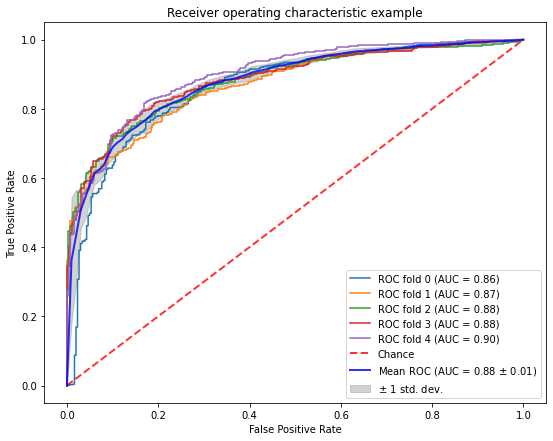

In [55]:
plot_multroc(tst_preds, k = 5)

In [56]:
file_name = "/content/drive/MyDrive/Colab Notebooks/pickle predictions/07. spot predictions.pkl"
with open(file_name, "wb") as fp:   #Pickling
   pickle.dump(tst_preds, fp)

In [57]:
pd.DataFrame(val_pct).to_csv("/content/drive/MyDrive/Colab Notebooks/validate/07. spot.csv")

In [58]:
pd.DataFrame(val_pct).mean()

0    0.446099
1    0.823696
2    0.749706
3    0.864553
4    0.904513
5    0.594900
6    0.759159
7    0.879247
dtype: float64